## Feature Engineering and Modeling

In order to train neural networks with lyrics data, the original dataset will need to be transformed. 

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
import numpy as np
from keras.backend import clear_session

In [2]:
songs = pd.read_csv('data/lemmatized_lyrics.csv')

In [3]:
songs.head()

,lyrics,genre,language,lyrics_str,length,TB_sentiment,V_sentiment,unique_words,nmf_topics,lda_topics
0,"['finger', 'white', 'like', 'whisper', 'lips',...",Rock,en,finger white like whisper lips consume flame l...,434,0.054167,0.9287,66,Life as a journey,"Death, faith"
1,"['need', 'know', 'much', 'want', 'broken', 'di...",Rock,en,need know much want broken die need know much ...,477,0.036667,-0.8176,38,Love and sexuality,"Life, love, longing"
2,"['ask', 'feel', 'love', 'real', 'know', 'make'...",Rock,en,ask feel love real know make look frown would ...,625,0.114815,0.9661,70,Love and fun,"Life, love, longing"
3,"['want', 'play', 'background', 'couple', 'drin...",Rock,en,want play background couple drink wine would t...,403,0.327273,0.9904,36,Love and sexuality,"Life, love, longing"
4,"['step', 'step', 'inch', 'inch', 'draw', 'clos...",Rock,en,step step inch inch draw close id wish little ...,519,-0.137083,0.6621,51,Love and fun,"Affection, women"


In [3]:
# As a pre-processing step, we use a LabelEncoder for the genres
le = preprocessing.LabelEncoder()
le.fit(songs.genre)
songs['label'] = le.transform(songs.genre)

In [31]:
le.classes_

array(['Country', 'Hip-hop', 'Metal', 'Pop', 'Rock'], dtype=object)

In [6]:
songs.label.value_counts()

3    18526
4    18514
1    18506
0    18495
2    18466
Name: label, dtype: int64

In [7]:
songs.head()

,lyrics,genre,language,lyrics_str,length,TB_sentiment,V_sentiment,unique_words,nmf_topics,lda_topics,label
0,"['finger', 'white', 'like', 'whisper', 'lips',...",Rock,en,finger white like whisper lips consume flame l...,434,0.054167,0.9287,66,Life as a journey,"Death, faith",4
1,"['need', 'know', 'much', 'want', 'broken', 'di...",Rock,en,need know much want broken die need know much ...,477,0.036667,-0.8176,38,Love and sexuality,"Life, love, longing",4
2,"['ask', 'feel', 'love', 'real', 'know', 'make'...",Rock,en,ask feel love real know make look frown would ...,625,0.114815,0.9661,70,Love and fun,"Life, love, longing",4
3,"['want', 'play', 'background', 'couple', 'drin...",Rock,en,want play background couple drink wine would t...,403,0.327273,0.9904,36,Love and sexuality,"Life, love, longing",4
4,"['step', 'step', 'inch', 'inch', 'draw', 'clos...",Rock,en,step step inch inch draw close id wish little ...,519,-0.137083,0.6621,51,Love and fun,"Affection, women",4


In [8]:
songs.to_csv('data/labeled_songs.csv', index=False)

## Establishing a base model

We will split our dataset and train a logistic regression model to establish a baseline performance metric.

In [4]:
# Splitting the dataset
X = songs.lyrics_str.values
y = songs.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1000)

In [5]:
# Creating a bag of words sparse matrix from a term frequency table using CountVectorizer()
vectorizer = CountVectorizer(max_df=0.85, min_df=100, max_features=2000) # We constrain the size of the vector
vectorizer.fit(X_train)
X_train_BOW = vectorizer.transform(X_train)
X_test_BOW  = vectorizer.transform(X_test)

In [6]:
# Scaling the data
scaler = preprocessing.MaxAbsScaler()
X_train_BOW = scaler.fit_transform(X_train_BOW)
X_test_BOW = scaler.transform(X_test_BOW)

In [111]:
# Logistic regression model
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=500)
classifier.fit(X_train_BOW, y_train)
score = classifier.score(X_test_BOW, y_test)

print("Accuracy:", score)

Accuracy: 0.6190599731915077


## Using Neural Networks

In [11]:
# We start with a basic keras Sequential model; code adapted from: 1. https://realpython.com/python-keras-text-classification/ and 2. https://medium.com/datadriveninvestor/deep-learning-techniques-for-text-classification-9392ca9492c7

from keras.models import Sequential
from keras import layers

clear_session()
input_dim = X_train_BOW.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(100, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               200100    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 505       
Total params: 200,605
Trainable params: 200,605
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(X_train_BOW.toarray(), y_train, epochs=60, verbose=2, 
                    validation_data=(X_test_BOW.toarray(), y_test), batch_size=1000)

Epoch 1/60
70/70 - 1s - loss: 1.4469 - accuracy: 0.4289 - val_loss: 1.2718 - val_accuracy: 0.5306
Epoch 2/60
70/70 - 0s - loss: 1.1827 - accuracy: 0.5805 - val_loss: 1.1076 - val_accuracy: 0.5955
Epoch 3/60
70/70 - 0s - loss: 1.0672 - accuracy: 0.6071 - val_loss: 1.0420 - val_accuracy: 0.6092
Epoch 4/60
70/70 - 0s - loss: 1.0114 - accuracy: 0.6193 - val_loss: 1.0111 - val_accuracy: 0.6179
Epoch 5/60
70/70 - 0s - loss: 0.9785 - accuracy: 0.6275 - val_loss: 0.9955 - val_accuracy: 0.6224
Epoch 6/60
70/70 - 0s - loss: 0.9563 - accuracy: 0.6342 - val_loss: 0.9866 - val_accuracy: 0.6244
Epoch 7/60
70/70 - 0s - loss: 0.9394 - accuracy: 0.6403 - val_loss: 0.9806 - val_accuracy: 0.6268
Epoch 8/60
70/70 - 0s - loss: 0.9260 - accuracy: 0.6442 - val_loss: 0.9771 - val_accuracy: 0.6281
Epoch 9/60
70/70 - 0s - loss: 0.9147 - accuracy: 0.6475 - val_loss: 0.9751 - val_accuracy: 0.6287
Epoch 10/60
70/70 - 0s - loss: 0.9051 - accuracy: 0.6501 - val_loss: 0.9724 - val_accuracy: 0.6287
Epoch 11/60
70/70 -

In [13]:
loss, accuracy = model.evaluate(X_train_BOW.toarray(), y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_BOW.toarray(), y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7733
Testing Accuracy:  0.6338


In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

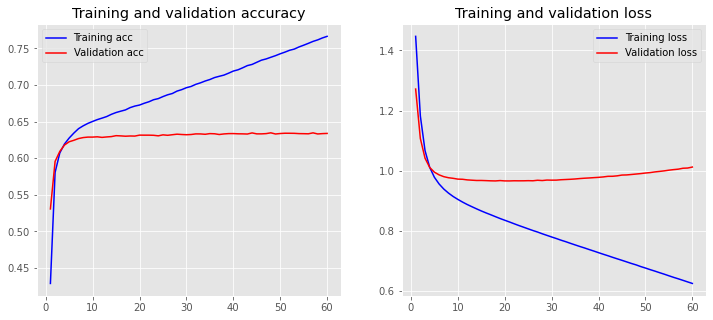

In [15]:
plot_history(history)

The results above improve the performance of a simple Sequential model, though some fine-tuning might be in order. We can see that validation accuracy stops improving after 20-30 epochs, and validation loss stagnates after 20 epochs. The model is re-run with a smaller epoch number and a smaller batch size.

Training Accuracy: 0.8627
Testing Accuracy:  0.6271


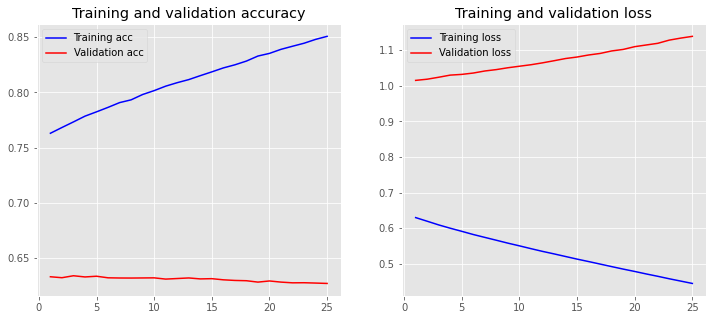

In [16]:
clear_session()
history = model.fit(X_train_BOW.toarray(), y_train, epochs=25, verbose=False, 
                    validation_data=(X_test_BOW.toarray(), y_test), batch_size=500)

loss, accuracy = model.evaluate(X_train_BOW.toarray(), y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_BOW.toarray(), y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

With the modifications made, the training accuracy improves, but the validation accuracy diminishes. The inverse is true for loss. One final experiment is made, tweaking the number of nodes in the first layer.

Training Accuracy: 0.6529
Testing Accuracy:  0.6287


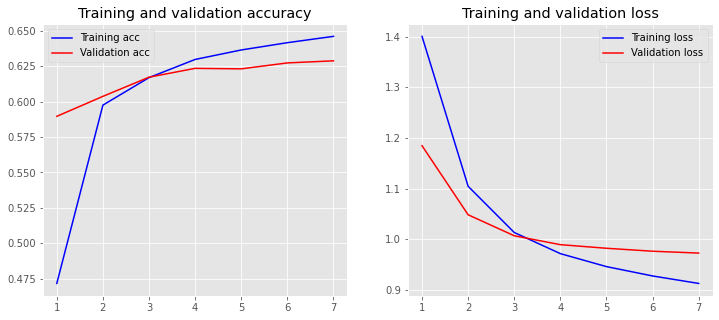

In [22]:
clear_session()
input_dim = X_train_BOW.shape[1]  # Number of features
model = Sequential()
model.add(layers.Dense(200, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_BOW.toarray(), y_train, epochs=7, verbose=False, 
                    validation_data=(X_test_BOW.toarray(), y_test), batch_size=1000)

loss, accuracy = model.evaluate(X_train_BOW.toarray(), y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_BOW.toarray(), y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history)

The results only show a minor improvement. This suggests that more systematic hyperparameter tuning is in order. For now, a different method is employed as part of the exploratory modeling phase.

In [35]:
# We look at a confusion matrix in order to identify labels that are often misclassified

from sklearn.metrics import confusion_matrix, classification_report

preds = model.predict(X_test_BOW)
preds = [pred.argmax() for pred in preds]
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(
        cm, index=le.classes_, columns=le.classes_, 
    )
df_cm.head()

,Country,Hip-hop,Metal,Pop,Rock
Country,3365,44,162,536,577
Hip-hop,163,3763,179,411,178
Metal,182,107,3588,195,532
Pop,914,357,355,2032,916
Rock,965,135,770,908,1793


In [36]:
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.60      0.72      0.66      4684
           1       0.85      0.80      0.83      4694
           2       0.71      0.78      0.74      4604
           3       0.50      0.44      0.47      4574
           4       0.45      0.39      0.42      4571

    accuracy                           0.63     23127
   macro avg       0.62      0.63      0.62     23127
weighted avg       0.62      0.63      0.62     23127



As the above results demonstrate, Hip-Hop and Metal are the two most distinct genres. Pop and Rock are fuzzier and harder to classifiy correctly. Country is somewhere in between.

## Using Word Embeddings

In [55]:
# We first use Tokenizer() on lyrics_str

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_WE = tokenizer.texts_to_sequences(X_train)
X_test_WE = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [69]:
# Because the vectores produced by Tokenizer are of variable lengths, now we pad with zeros to ensure all vectors
# have the same length

# First, we determine the longest list produced by Tokenizer

list_lengths = [len(wordlist) for wordlist in X_train_WE]
maxlen = max(list_lengths) + 500

from keras.preprocessing.sequence import pad_sequences

X_train_WE = pad_sequences(X_train_WE, padding='post', maxlen=maxlen)
X_test_WE = pad_sequences(X_test_WE, padding='post', maxlen=maxlen)

In [132]:
# We create a neural network with an embedding layer that maps Vectorizer integers to dense vectors, reducing
# dimensionality.

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2955, 50)          5611200   
_________________________________________________________________
flatten (Flatten)            (None, 147750)            0         
_________________________________________________________________
dense (Dense)                (None, 50)                7387550   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
Total params: 12,999,005
Trainable params: 12,999,005
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
70/70 [==============================] - 42s 593ms/step - loss: 2.0287 - accuracy: 0.1915 - val_loss: 1.4839 - val_accuracy: 0.2134
Epoch 2/10
70/70 [==============================] - 50s 719ms/step - loss: 1.4315 - accuracy: 0.3294 - val_loss: 1.3193 - val_accuracy: 0.4451
Epoch 3/10
70/70 [==============================] - 70s 1s/step - loss: 1.2994 - accuracy: 0.4586 - val_loss: 1.2485 - val_accuracy: 0.4935
Epoch 4/10
70/70 [==============================] - 52s 740ms/step - loss: 1.2095 - accuracy: 0.4991 - val_loss: 1.1640 - val_accuracy: 0.5338
Epoch 5/10
70/70 [==============================] - 51s 724ms/step - loss: 1.1193 - accuracy: 0.5454 - val_loss: 1.0671 - val_accuracy: 0.5800
Epoch 6/10
70/70 [==============================] - 51s 732ms/step - loss: 1.0132 - accuracy: 0.6025 - val_loss: 1.0323 - val_accuracy: 0.6000
Epoch 7/10
70/70 [==============================] - 48s 686ms/step - loss: 0.9682 - accuracy: 0.6234 - val_loss: 1.0153 - val_accuracy: 0.6065
Ep

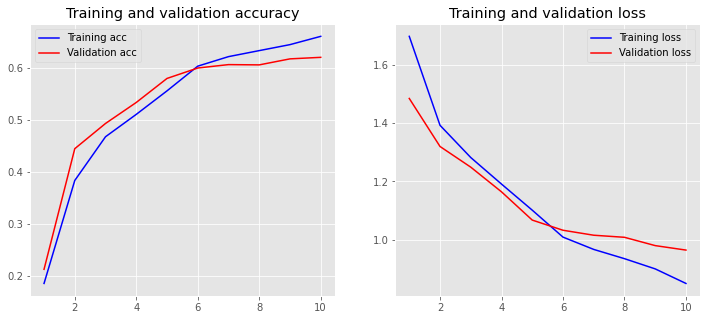

In [133]:
history = model.fit(X_train_WE, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test_WE, y_test),
                    batch_size=1000)

loss, accuracy = model.evaluate(X_train_WE, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_WE, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)


The results above show that we might need to continue training over a higher number of epochs. The code below does just that: increasing from 10 to 25 without clearing the session.

Epoch 1/25
70/70 [==============================] - 41s 579ms/step - loss: 0.8140 - accuracy: 0.6745 - val_loss: 0.9579 - val_accuracy: 0.6227
Epoch 2/25
70/70 [==============================] - 42s 595ms/step - loss: 0.7832 - accuracy: 0.6874 - val_loss: 0.9735 - val_accuracy: 0.6200
Epoch 3/25
70/70 [==============================] - 52s 745ms/step - loss: 0.7483 - accuracy: 0.7021 - val_loss: 0.9719 - val_accuracy: 0.6230
Epoch 4/25
70/70 [==============================] - 49s 707ms/step - loss: 0.7095 - accuracy: 0.7182 - val_loss: 0.9882 - val_accuracy: 0.6213
Epoch 5/25
70/70 [==============================] - 46s 663ms/step - loss: 0.6690 - accuracy: 0.7368 - val_loss: 1.0047 - val_accuracy: 0.6207
Epoch 6/25
70/70 [==============================] - 51s 727ms/step - loss: 0.6237 - accuracy: 0.7573 - val_loss: 1.0374 - val_accuracy: 0.6134
Epoch 7/25
70/70 [==============================] - 51s 733ms/step - loss: 0.5798 - accuracy: 0.7765 - val_loss: 1.0691 - val_accuracy: 0.6089

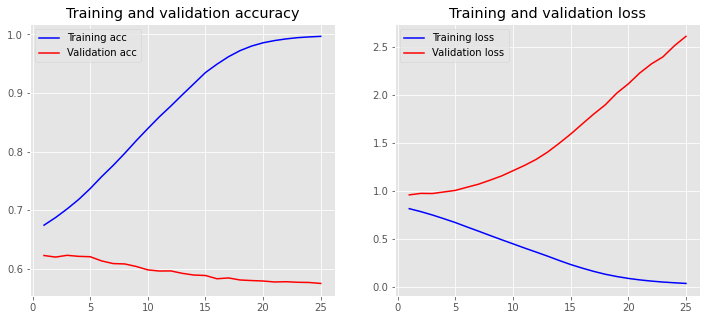

In [134]:
history = model.fit(X_train_WE, y_train,
                    epochs=25,
                    verbose=True,
                    validation_data=(X_test_WE, y_test),
                    batch_size=1000)

loss, accuracy = model.evaluate(X_train_WE, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_WE, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Further epochs lead to overfitting. The ideal number might be 10 (from the prior training) + 5 (indicated in the graphs above). We now experiment with results using Global Max Pooling after embedding as a way to further reduce the dimensionality of incoming feature vectors.

In [137]:
clear_session()
embedding_dim = 50
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2955, 50)          5611200   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 255       
Total params: 5,614,005
Trainable params: 5,614,005
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.7880
Testing Accuracy:  0.6352


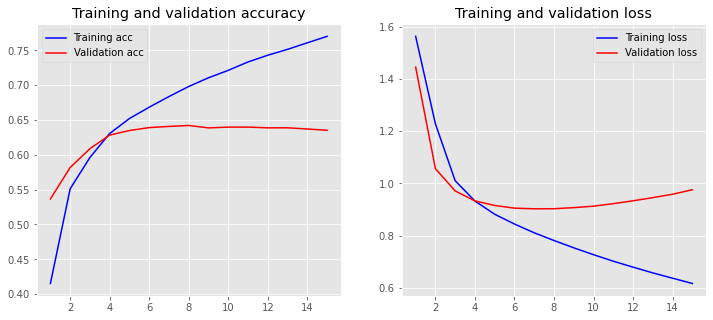

In [138]:
# The code for training does not change:

history = model.fit(X_train_WE, y_train,
                    epochs=15,
                    verbose=False,
                    validation_data=(X_test_WE, y_test),
                    batch_size=1000)

loss, accuracy = model.evaluate(X_train_WE, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_WE, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

The results above show that adding a max pooling layer is not especially helpful. The validation accuracy and the validation loss stagnate after approximately 5 epochs.

Another common approach is to use pre-existing, pre-trained word embeddings rather than creating our own based on our local corpus. In what follows, the embeddings used by GloVe (Global Vectors for Word Representation)--developed by the Stanford NLP Group--are employed. Specifically, the word embeddings from the [Wikipedia 2014 + Gigaword 5](http://nlp.stanford.edu/data/glove.6B.zip) 6 billion token model is used (the size of the vocabulary is 400k).

In [140]:
# The following function creates an embedding matrix.

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [146]:
# Now we create the embedding matrix

embedding_dim = 50
embedding_matrix = create_embedding_matrix('data/glove.6B/glove.6B.50d.txt', 
                                            tokenizer.word_index, embedding_dim)

# We also examine the percentage of the vocabulary that is covered by the pretrained model
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print("The percentage of our vocabulary that is covered by the pretrained model is:",100 * nonzero_elements / vocab_size, "%")

The percentage of our vocabulary that is covered by the pretrained model is: 50.65315796977474 %


As the above result suggests, we might not get very good results from using pre-trained word embeddings in this particular case. But let's test it empirically.

In [153]:
clear_session()
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2955, 50)          5611200   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
Total params: 5,611,765
Trainable params: 565
Non-trainable params: 5,611,200
_________________________________________________________________


Epoch 1/50
70/70 - 16s - loss: 1.5892 - accuracy: 0.2505 - val_loss: 1.5452 - val_accuracy: 0.2771
Epoch 2/50
70/70 - 15s - loss: 1.5300 - accuracy: 0.2804 - val_loss: 1.5018 - val_accuracy: 0.2944
Epoch 3/50
70/70 - 16s - loss: 1.4901 - accuracy: 0.3027 - val_loss: 1.4639 - val_accuracy: 0.3179
Epoch 4/50
70/70 - 16s - loss: 1.4573 - accuracy: 0.3199 - val_loss: 1.4350 - val_accuracy: 0.3386
Epoch 5/50
70/70 - 16s - loss: 1.4322 - accuracy: 0.3410 - val_loss: 1.4119 - val_accuracy: 0.3537
Epoch 6/50
70/70 - 16s - loss: 1.4123 - accuracy: 0.3522 - val_loss: 1.3943 - val_accuracy: 0.3590
Epoch 7/50
70/70 - 16s - loss: 1.3959 - accuracy: 0.3580 - val_loss: 1.3785 - val_accuracy: 0.3690
Epoch 8/50
70/70 - 16s - loss: 1.3811 - accuracy: 0.3650 - val_loss: 1.3642 - val_accuracy: 0.3729
Epoch 9/50
70/70 - 16s - loss: 1.3671 - accuracy: 0.3719 - val_loss: 1.3503 - val_accuracy: 0.3780
Epoch 10/50
70/70 - 16s - loss: 1.3538 - accuracy: 0.3874 - val_loss: 1.3363 - val_accuracy: 0.4033
Epoch 11/

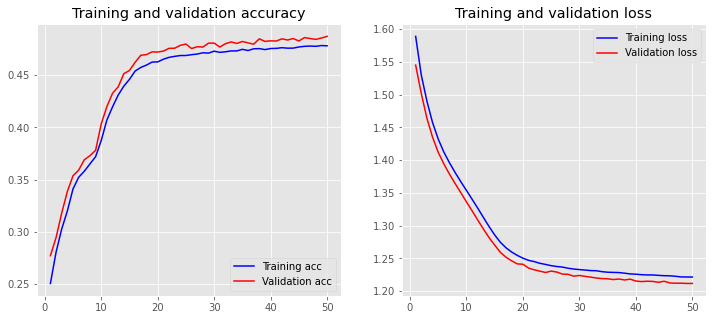

In [154]:
history = model.fit(X_train_WE, y_train,
                    epochs=50,
                    verbose=2,
                    validation_data=(X_test_WE, y_test),
                    batch_size=1000)
loss, accuracy = model.evaluate(X_train_WE, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_WE, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

The above results suggest that with such a low representation of our vocabulary (50%), a pre-trained word embeddings model cannot realistically obtain an accuracy higher than the percentage of representation. Now we observe if anything changes once we allow the embedding to be trainable, by setting the hyperparameter "trainable" to True.

In [155]:
clear_session()
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2955, 50)          5611200   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
Total params: 5,611,765
Trainable params: 5,611,765
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
70/70 - 46s - loss: 1.6545 - accuracy: 0.2274 - val_loss: 1.5435 - val_accuracy: 0.3144
Epoch 2/30
70/70 - 45s - loss: 1.4885 - accuracy: 0.3606 - val_loss: 1.4257 - val_accuracy: 0.3997
Epoch 3/30
70/70 - 46s - loss: 1.3594 - accuracy: 0.4331 - val_loss: 1.2942 - val_accuracy: 0.4627
Epoch 4/30
70/70 - 47s - loss: 1.2498 - accuracy: 0.4848 - val_loss: 1.2066 - val_accuracy: 0.4983
Epoch 5/30
70/70 - 46s - loss: 1.1752 - accuracy: 0.5150 - val_loss: 1.1488 - val_accuracy: 0.5202
Epoch 6/30
70/70 - 48s - loss: 1.1238 - accuracy: 0.5370 - val_loss: 1.1084 - val_accuracy: 0.5381
Epoch 7/30
70/70 - 48s - loss: 1.0870 - accuracy: 0.5544 - val_loss: 1.0809 - val_accuracy: 0.5516
Epoch 8/30
70/70 - 47s - loss: 1.0586 - accuracy: 0.5659 - val_loss: 1.0590 - val_accuracy: 0.5645
Epoch 9/30
70/70 - 47s - loss: 1.0343 - accuracy: 0.5787 - val_loss: 1.0399 - val_accuracy: 0.5736
Epoch 10/30
70/70 - 47s - loss: 1.0143 - accuracy: 0.5873 - val_loss: 1.0266 - val_accuracy: 0.5804
Epoch 11/

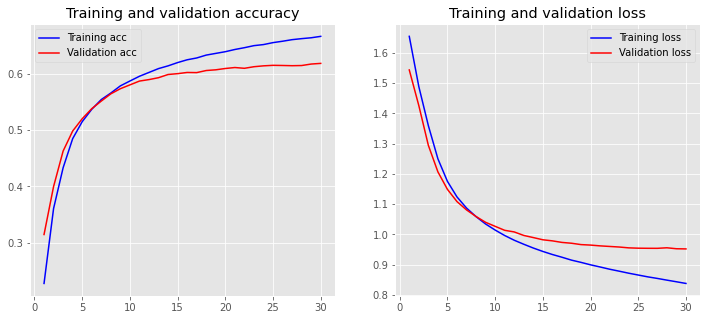

In [157]:
history = model.fit(X_train_WE, y_train,
                    epochs=30,
                    verbose=2,
                    validation_data=(X_test_WE, y_test),
                    batch_size=1000)
loss, accuracy = model.evaluate(X_train_WE, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_WE, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

The results above confirm that allowing the embeddings to be trainable improves the model's accuracy. Training is repeated below with a higher epoch number.

In [164]:
clear_session()
embedding_dim = 50
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2955, 50)          5611200   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                510       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
Total params: 5,611,765
Trainable params: 5,611,765
Non-trainable params: 0
_________________________________________________________________


In [165]:
history = model.fit(X_train_WE, y_train,
                    epochs=50,
                    verbose=2,
                    validation_data=(X_test_WE, y_test),
                    batch_size=1000)

Epoch 1/50
70/70 - 47s - loss: 1.8710 - accuracy: 0.2242 - val_loss: 1.5866 - val_accuracy: 0.2700
Epoch 2/50
70/70 - 48s - loss: 1.5418 - accuracy: 0.3213 - val_loss: 1.4977 - val_accuracy: 0.3646
Epoch 3/50
70/70 - 48s - loss: 1.4500 - accuracy: 0.3942 - val_loss: 1.4006 - val_accuracy: 0.4198
Epoch 4/50
70/70 - 48s - loss: 1.3557 - accuracy: 0.4387 - val_loss: 1.3118 - val_accuracy: 0.4586
Epoch 5/50
70/70 - 48s - loss: 1.2773 - accuracy: 0.4693 - val_loss: 1.2455 - val_accuracy: 0.4794
Epoch 6/50
70/70 - 52s - loss: 1.2185 - accuracy: 0.4935 - val_loss: 1.1964 - val_accuracy: 0.4974
Epoch 7/50
70/70 - 51s - loss: 1.1723 - accuracy: 0.5130 - val_loss: 1.1566 - val_accuracy: 0.5186
Epoch 8/50
70/70 - 50s - loss: 1.1347 - accuracy: 0.5315 - val_loss: 1.1254 - val_accuracy: 0.5364
Epoch 9/50
70/70 - 51s - loss: 1.1035 - accuracy: 0.5453 - val_loss: 1.0999 - val_accuracy: 0.5470
Epoch 10/50
70/70 - 51s - loss: 1.0767 - accuracy: 0.5594 - val_loss: 1.0787 - val_accuracy: 0.5586
Epoch 11/

Training Accuracy: 0.7072
Testing Accuracy:  0.6232


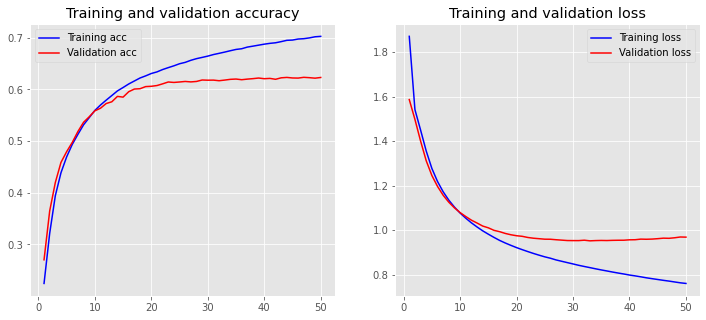

In [166]:
loss, accuracy = model.evaluate(X_train_WE, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_WE, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

The trainable embedding and max pooling model appears to stagnate around 30 epochs, around a 62% of accuracy.

## Convolutional Neural Networks

Finally, we also apply CNNs as a way to generate and explore hidden patterns in our dataset. More specifically, a convolutional layer is added between embedding and pooling.

In [167]:
clear_session()
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2955, 100)         11222400  
_________________________________________________________________
conv1d (Conv1D)              (None, 2951, 128)         64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
Total params: 11,287,873
Trainable params: 11,287,873
Non-trainable params: 0
_________________________________________________________________


In [168]:
history = model.fit(X_train_WE, y_train,
                    epochs=30,
                    verbose=2,
                    validation_data=(X_test_WE, y_test),
                    batch_size=1000)

Epoch 1/30
70/70 - 504s - loss: 1.4809 - accuracy: 0.4147 - val_loss: 1.2361 - val_accuracy: 0.5390
Epoch 2/30
70/70 - 504s - loss: 1.0669 - accuracy: 0.5908 - val_loss: 0.9601 - val_accuracy: 0.6226
Epoch 3/30
70/70 - 503s - loss: 0.8959 - accuracy: 0.6543 - val_loss: 0.9249 - val_accuracy: 0.6368
Epoch 4/30
70/70 - 507s - loss: 0.8294 - accuracy: 0.6828 - val_loss: 0.9213 - val_accuracy: 0.6402
Epoch 5/30
70/70 - 507s - loss: 0.7741 - accuracy: 0.7104 - val_loss: 0.9253 - val_accuracy: 0.6402
Epoch 6/30
70/70 - 505s - loss: 0.7214 - accuracy: 0.7335 - val_loss: 0.9333 - val_accuracy: 0.6401
Epoch 7/30
70/70 - 505s - loss: 0.6690 - accuracy: 0.7572 - val_loss: 0.9518 - val_accuracy: 0.6393
Epoch 8/30
70/70 - 504s - loss: 0.6122 - accuracy: 0.7833 - val_loss: 0.9714 - val_accuracy: 0.6386
Epoch 9/30
70/70 - 503s - loss: 0.5508 - accuracy: 0.8127 - val_loss: 1.0009 - val_accuracy: 0.6364
Epoch 10/30
70/70 - 503s - loss: 0.4883 - accuracy: 0.8415 - val_loss: 1.0441 - val_accuracy: 0.6309

Training Accuracy: 0.9982
Testing Accuracy:  0.6085


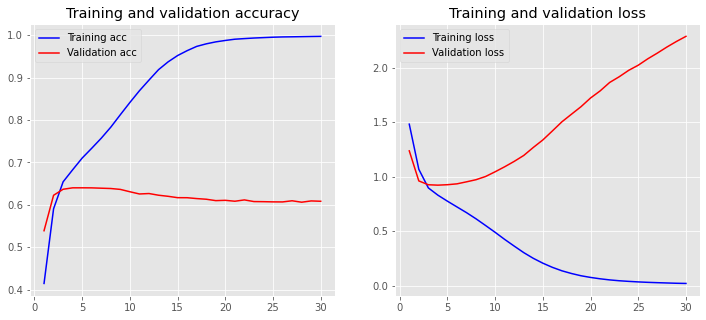

In [169]:
loss, accuracy = model.evaluate(X_train_WE, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_WE, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Convolutional networks quickly start overfitting, and testing accuracy stagnates in a similar range as do all other models.

## Some final checks: The trusty random forest

Neural networks are not always the answer. Random forests are especially equipped to deal with sparsity. We run a couple experiments for comparison purposes.

In [172]:
# Vanilla random forest model with BOW inputs
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train_BOW, y_train)
score = classifier.score(X_test_BOW, y_test)

print("Accuracy:", score)

Accuracy: 0.6198815237601072


In [173]:
# Vanilla random forest model with word embedding inputs
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train_WE, y_train)
score = classifier.score(X_test_WE, y_test)

print("Accuracy:", score)

Accuracy: 0.4447182946339776


In [9]:
# Naive Bayes

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

tfidf_vectorizer = TfidfVectorizer(max_df=0.85, min_df=100, max_features=2955, use_idf=True)
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

clf = MultinomialNB().fit(X_train_tfidf, y_train)
score = clf.score(X_test_tfidf, y_test)

print("Accuracy:", score)

Accuracy: 0.6144765858087949


## Conclusions

The results above show that a Random Forest Classifier trained on a Bag of Words representation, as with Logistic Regression, appears to produce similar results as neural networks. If this application were to be deployed, neural networks would not be favored as an appropriate solution, as the yielded results do not improve significantly on simpler models, but are much more computationally expensive.

The next steps would require further testing with hyperparameter tuning using simple models and one of the less computationally expensive neural networks. Additional neural networks could be experimented with, such as a Long Short-Term Memory (LSTM) neural network, Recurrent Neural Networks (RNN), Gated Recurrent Unit (GRU), Hierarchical Attention Networks, Recurrent Convolutional Neural Networks (RCNN), Random Multimodel Deep Learning (RMDL), and Hierarchical Deep Learning for Text (HDLTex).

Ultimately, the question might lie in the quality of the data, as the acquired datasets come from multiple sources and data quality is certainly an issue. This project ultimately demonstrates that one of the more crucial steps in the data science lifecycle concerns data acquisition and quality. In this case, generating a tidy lyrics dataset would produce high pre-processing costs.